## Import TensorFlow and other libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import StandardScaler, Normalizer, PowerTransformer
from sklearn.model_selection import train_test_split
from tensorflow.keras import losses

import matplotlib.pyplot as plt

# Print tensorflow version. This code has been tested with 2.3.0
print(f'Tensorflow Version: {tf.__version__}')

Tensorflow Version: 2.3.0


## Restrict Tensorflow GPU memory usage

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

## Parameter definition

In [3]:
# Design id
#
# * 0: Non-linear front-end with ADC quantization
# * 1: Non-linear front-end without ADC quantization
# * 2: Linear front-end with ADC quantization
# * 3: Linear front-end without ADC quantization
id = 0
it = 1      # iteration

nrx = 16    # num of receiver antennas
nsnr = 31   # num of snr points
nx = 10000  # num of tx samples

## Read the data from the input files

In [4]:
# Read the randomly generated tx symbols
df = pd.read_csv(r'../../datasets/rx_1/idata_'+str(it)+'.csv')
x = np.char.replace(np.array(df['x'],dtype=str),'i','j').astype(np.complex)

# Read the channel w
w = np.array([np.char.replace(np.array(df['w_'+str(i+1)],dtype=str),'i','j').astype(np.complex)
              for i in range(nrx)], dtype=complex)

# Signal at each rx antenna.
y_ant = np.array([np.char.replace(np.array(df['yant_'+str(isnr*nrx+irx+1)],dtype=str),'i','j').astype(np.complex)
              for isnr in range(nsnr) for irx in range(nrx) ], dtype=complex).T.reshape(nx*nsnr,nrx)

# Read the output of the non-linear function
df = pd.read_csv(r'../../datasets/rx_1/odata_'+str(id+1)+'_'+str(it)+'.csv')
y_rffe = np.array([np.char.replace(np.array(df['yrffe_'+str(isnr*nrx+irx+1)],dtype=str),'i','j').astype(np.complex)
                    for isnr in range(nsnr) for irx in range(nrx)]).T.reshape(nx*nsnr,nrx)

# Read the estimated received symbols x_hat
x_hat = np.array([np.char.replace(np.array(df['xhat_'+str(i+1)],dtype=str),'i','j').astype(np.complex)
              for i in range(nsnr)], dtype=complex).T.reshape(-1,1)

# Read the input Power array in dBm
df = pd.read_csv(r'../../datasets/rx_1/param_1_'+str(id+1)+'_'+str(it)+'.csv')
power_in = df['Pin']

# Print the shape for some of the arrays
print(f'y_ant shape: {y_ant.shape}')
print(f'y_rffe shape: {y_rffe.shape}')

y_ant shape: (310000, 16)
y_rffe shape: (310000, 16)


## Define some helper functions

In [5]:
def snr(Phi):
    xh = sum(Phi.T*np.conj(w),0)/np.sum(np.abs(w)**2,0)
    a = np.mean(np.conj(xh)*x)/np.mean(np.abs(x)**2)
    d_var = np.mean(np.abs(xh - a*x)**2)
    snr_out = 10*np.log10(np.abs(a)**2/d_var)
    return snr_out

## Prepare the input data

In [6]:
xw = (w*x).T
xw = np.repeat(xw, nsnr, axis=0)

r = np.hstack((y_ant.real, y_ant.imag))
X = np.hstack((y_rffe.real,
               y_rffe.imag,
               ))

x_train, x_test, y_train, y_test = train_test_split(X, r, shuffle=True, test_size=0.1)

scale_in = StandardScaler(with_mean=True, with_std=True).fit(X)
scale_out = StandardScaler(with_mean=True, with_std=True).fit(r)

x_train = scale_in.transform(x_train)
x_test = scale_in.transform(x_test)
y_train = scale_out.transform(y_train)
y_test = scale_out.transform(y_test)

print(f'x_train shape: {x_train.shape}')

x_train shape: (279000, 32)


## Define and train the neural network
* The model includes both fully-connected and convolutional layers.

In [9]:
# Define the parameters for the layers of the model
fc_in_bias_init = 'random_normal'
fc_in_bias_reg = 'l1'
fc_in_activation = 'linear'

cnn_bias_init = 'random_normal'
cnn_bias_reg = 'l1'
cnn_activation = 'linear'

fc_out_bias_init = 'random_normal'
fc_out_bias_reg = 'l1'
fc_out_activation = 'linear'

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(32,)),
    # First, we use a series of Fully-Connected layers at the
    # input of the Model with linear activation.
    tf.keras.layers.Dense(64,
                          activation=fc_in_activation,
                          # bias_regularizer=fc_in_bias_reg,
                          bias_initializer=fc_in_bias_init),
    tf.keras.layers.Dense(128,
                          activation=fc_in_activation,
                          # bias_regularizer=fc_in_bias_reg,
                          bias_initializer=fc_in_bias_init),
    tf.keras.layers.Dense(256,
                          activation=fc_in_activation,
                          # bias_regularizer=fc_in_bias_reg,
                          bias_initializer=fc_in_bias_init),
    # Then, we use a series of Fully-Connected layers at the
    # input of the Model with linear activation.
    tf.keras.layers.Reshape((16,16), input_shape=(256,)),
    tf.keras.layers.Conv1D(filters=16,
                           kernel_size=16,
                           padding = 'same',
                           input_shape=(16,16),
                           activation=cnn_activation,
                           # bias_regularizer=cnn_bias_reg,
                           bias_initializer=cnn_bias_init),
    tf.keras.layers.Conv1D(filters=16,
                           kernel_size=16,
                           padding = 'same',
                           input_shape=(16,16),
                           activation=cnn_activation,
                           # bias_regularizer=cnn_bias_reg,
                           bias_initializer=cnn_bias_init),
    tf.keras.layers.Conv1D(filters=16,
                           kernel_size=16,
                           padding = 'same',
                           input_shape=(16,16),
                           activation=cnn_activation,
                           # bias_regularizer=cnn_bias_reg,
                           bias_initializer=cnn_bias_init),
    tf.keras.layers.Reshape((256,), input_shape=(16,16)),
    # Finally, we use a series of Fully-Connected layers at the
    # output of the Model.
    tf.keras.layers.Dense(128,
                          activation=fc_out_activation,
                          # bias_regularizer=fc_out_bias_reg,
                          bias_initializer=fc_out_bias_init),
    tf.keras.layers.Dense(64,
                          activation=fc_out_activation,
                          # bias_regularizer=fc_out_bias_reg,
                          bias_initializer=fc_out_bias_init),
    tf.keras.layers.Dense(32,
                          activation='linear',
                          # bias_regularizer=fc_out_bias_reg,
                          bias_initializer=fc_out_bias_init),
])

# Set the optimizer and the loss function of the neural network
model.compile(optimizer='sgd',
              loss=losses.MeanSquaredError())

# Train the neural network
model.fit(x_train, y_train,
          epochs=5,
          batch_size=128,
          shuffle=True,
          validation_data=(x_test,y_test))

Epoch 1/5
2180/2180 [==============================] - 13s 6ms/step - loss: 0.7774 - val_loss: 0.7209

## Test the performance of the neural network

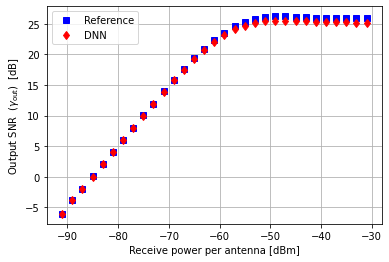

In [10]:
pred = model(scale_in.transform(X)).numpy()

# Find the complex data
pred = pred[:, 0:16] + 1j * pred[:, 16:32]
pred = pred.reshape(nx, nsnr, nrx)

# Baseline data
base = y_rffe.reshape(nx, nsnr, nrx)

pred_snr = np.zeros(nsnr)
base_snr = np.zeros(nsnr)

for isnr in range(nsnr):
    pred_snr[isnr] = snr(pred[:,isnr,:])
    base_snr[isnr] = snr(base[:,isnr,:])

plt.plot(power_in, base_snr, 'bs')
plt.plot(power_in, pred_snr, 'rd')
plt.grid()
plt.xlabel('Receive power per antenna [dBm]')
plt.ylabel('Output SNR $\;(\gamma_\mathrm{out})\;$ [dB]')
plt.legend(['Reference', 'DNN'])